In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This workbook plots a binary mixture diagram using the Wilson model for fluid interactions and antoine's model for individual component vapour pressures.

In [2]:
reference_pressure=1.0123 # bar (be careful, the units in this are not great - engineers!)
reference_ethanol_density=0.78924 # g/mL @ 20 deg C
reference_water_density=0.99819 # g/mL @ 20 deg C
molar_mass_ethanol=46.069 # g/mol
molar_mass_water=18.015 #g/mol

Defining constants and coefficients for the following calculations. Antoine parameters are given for mmHg (torr), which is traditional but not very helpful! Where possible I have tried to minimise the switching of unit systems and labelled all units used.

In [3]:
bar_to_torr=750.06376
R=1.987 #kcal⋅K−1⋅mol−1

# critical pressure (bar), critical temperature (K)
# activity coefficient is a binary parameter, so the activity coefficient
# is for water 'with respect to ethanol'
ethanol={'A':18.91,
         'B':3803.98,
         'C':-41.68,
         'pc':63.83,
       'tc':516.20, 
       'Zra':0.2502,
      'activity':325.08}
water={'A':18.30,
       'B':3816.44,
       'C':-46.13,
       'pc':220.48,
       'tc':647.30, 
       'Zra':0.2338,
      'activity':953.28}

Now define functions to calculate the various parameters: Psat, Tsat, activity, and volume.

In [4]:
# calculations for saturation temperatures
def calc_tsat_ethanol(pressure):
    return ethanol['B']/(ethanol['A']-math.log(pressure*bar_to_torr))-ethanol['C'] # deg K

def calc_tsat_water(pressure):
    return water['B']/(water['A']-math.log(pressure*bar_to_torr))-water['C'] # deg K

# calculations for molar volumes
def calc_vm_ethanol(temperature):
    return (83.14*(ethanol['tc']/ethanol['pc']))*ethanol['Zra']**(1+(1-(temperature/ethanol['tc']))**(2.0/7.0))

def calc_vm_water(temperature):
    return (83.14*(water['tc']/water['pc']))*water['Zra']**(1+(1-(temperature/water['tc']))**(2.0/7.0))

# calculations for activity coefficient and Wilson model parameters
def calc_activity(x,y12,y21):
    return math.exp(-1*math.log(x+(1-x)*y12)+(1-x)*(y12/(x+(1-x)*y12)-y21/(1-x+x*y21)))

def calc_y(t,v1,v2,activ):
    return (v2/v1)*math.exp(-1*activ/(R*t))

# back calculate saturatin pressure of the mixture from the given parameters
def new_psat(x,p,t,L1,L2):
    # replace 1.0 with bar_to_torr to return torr - stupid engineering calculations!
    return (p*1.0)/(x*L1+(1-x)*L2*math.exp(water['A']-water['B']/(t+water['C']))/math.exp(ethanol['A']-ethanol['B']/(t+ethanol['C']))) # bar

## VLE calculations 

The calculations above can be used to find the saturation temperature given a mole fraction of ethanol (classically defined as species 1) and water (usually defined as species 2 because it is less volatile). The basic algorithm is:
1. Calculate an initial guess for saturation temperature (linear interpolation is fine to start)
2. Calculate molar volume and mixture binary interaction parameters (using the Wilson model here, although others are available
3. Calculate a saturation pressure given the above,
4. Re-calculate the saturation temperature given the newly calculated pressure

This is an iterative procedure, which usually works well in 10 iterations or less.

In [5]:
def calculate_VLE_temperature_bubble(x):
    # x is mole fraction of most volatile component, usually defined as '1'
    # pure ethanol saturation temperature
    ethanol_saturation_temperature=calc_tsat_ethanol(reference_pressure)
    water_saturation_temperature=calc_tsat_water(reference_pressure)
    #print('pure ethanol tsat (@ {:.2f} bar): {:.2f}'.format(reference_pressure,ethanol_saturation_temperature))
    #print('pure water tsat (@ {:.2f} bar): {:.2f}'.format(reference_pressure,water_saturation_temperature))
    # calculate starting point
    t_1=x*ethanol_saturation_temperature+(1.0-x)*water_saturation_temperature
    max_iters=10
    iters=0
    dt_tolerance=0.001
    iterate=True
    while iterate:
        v_1=calc_vm_ethanol(t_1)
        v_2=calc_vm_water(t_1)
        lam1=calc_activity(x,calc_y(t_1,v_1,v_2,ethanol['activity']),calc_y(t_1,v_2,v_1,water['activity']))
        lam2=calc_activity(1.0-x,calc_y(t_1,v_2,v_1,water['activity']),calc_y(t_1,v_1,v_2,ethanol['activity']))
        ps=new_psat(x,reference_pressure,t_1,lam1,lam2)
        t_next=calc_tsat_ethanol(ps)
        iters=iters+1
        if iters==max_iters:
            iterate=False
        if abs(t_next-t_1)<dt_tolerance:
            iterate=False
        t_1=t_next
    return t_1

def calculate_vapour_fraction(x):
    t=calculate_VLE_temperature_bubble(x)
    v_1=calc_vm_ethanol(t)
    v_2=calc_vm_water(t)
    lam1=calc_activity(x,calc_y(t,v_1,v_2,ethanol['activity']),calc_y(t,v_2,v_1,water['activity']))
    return x*lam1*math.exp(ethanol['A']-ethanol['B']/(t+ethanol['C']))/(reference_pressure*bar_to_torr)

Example calculation: mole fraction of ethanol, 0.2, should have a saturation pressure of 356.9 deg K

In [6]:
mol_fraction=0.2
print('{:.2f} deg K'.format(calculate_VLE_temperature_bubble(mol_fraction)))
print('vapour fraction at saturation temperature for {} mole fraction is {:.3f}'.format(mol_fraction,calculate_vapour_fraction(mol_fraction)))

356.96 deg K
vapour fraction at saturation temperature for 0.2 mole fraction is 0.521


In [7]:
xs=np.arange(start=0.0,stop=1.0,step=0.01)
y_bubble = [ calculate_VLE_temperature_bubble(x) for x in xs ]
x_dew = [ calculate_vapour_fraction(x) for x in xs ]

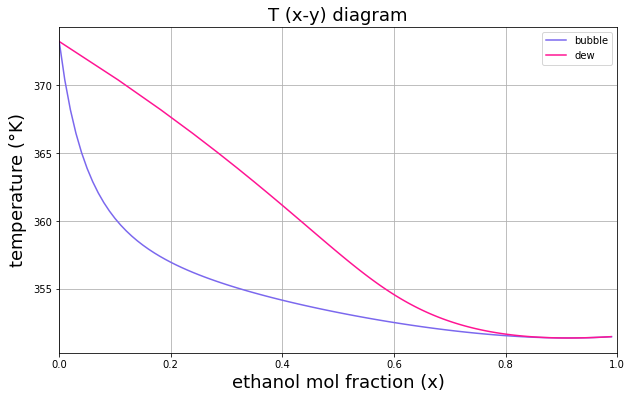

In [8]:
font={'family':'sans-serif',
         'size':18,
         'color':'black'}

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(xs, y_bubble,color='mediumslateblue',label='bubble')
ax.plot(x_dew,y_bubble,color='deeppink',label='dew')

ax.set_xlabel('ethanol mol fraction (x)',fontdict=font) 
ax.set_ylabel('temperature ($\degree$K)',fontdict=font) 
ax.set_title('T (x-y) diagram',fontdict=font) 
plt.xlim(0.0,1.0)
ax.grid()
plt.legend()

plt.show()

## volumetric calculations 

Calculate the excess molar volume for the mixtures to allow relation of mole fraction to ABV%. Using the Redlich-Kister model. 

In [17]:
def excess_molar_volume_water_ethanol(x,t):
    # x is the mol fraction of ethanol
    # degrees K
    # parameter 1: cm3.mol-1
    # parameter 2: cm3.mol-1.K-1
    A=-9.054199+0.01572057*t
    B=-4.930763+0.01241796*t
    C=5.286817-0.01989784*t
    Ve=x*(1.0-x)*(A+B*(1.0-2*x)+C*(1.0-2*x)**2)
    return Ve

def water_ethanol_mixture_density(x_ethanol,t):
    ve=excess_molar_volume_water_ethanol(x_ethanol,t)
    v1=calc_vm_water(t)
    v2=calc_vm_ethanol(t)
    vm=ve+((1.0-x_ethanol)*v1+x_ethanol*v2)
    return ((1.0-x_ethanol)*molar_mass_water+x_ethanol*molar_mass_ethanol)/vm

def calc_abv_from_pure_vol_fraction(e,w,t):
    #e is ethanol volume mL
    #w is water volume mL
    mol_water=w/calc_vm_water(t)
    mol_ethanol=e/calc_vm_ethanol(t)
    #mol fraction of ethanol
    x=mol_ethanol/(mol_ethanol+mol_water)
    #excess molar volumn
    ve=excess_molar_volume_water_ethanol(x,t)
    # total volume of final solution
    total_volume=e+w+(ve*(mol_water+mol_ethanol))
    #abv is volume of ethanol over total volume as a %
    return e/total_volume*100

def lookup_mol_fraction_ethanol_from_abv(abv,t):
    # basis 1 mol of each
    # xs is mol fraction of ethanol
    vols_ethanol=[ x*calc_vm_ethanol(t) for x in xs ]
    vols_water=[ (1.0-x)*calc_vm_water(t) for x in xs ]
    abvs=[ calc_abv_from_pure_vol_fraction(e,w,t) for e,w in zip(vols_ethanol,vols_water) ]
    return np.interp(abv,abvs,xs)
    
# test values from known reference values
print(calc_abv_from_pure_vol_fraction(50,50,20.0+273.15))
print(lookup_mol_fraction_ethanol_from_abv(40.0,20.0+273.15))
print(lookup_mol_fraction_ethanol_from_abv(18.4,20.0+273.15))

print('dads gin')
vodka_abv=40.0
vodka_mol=lookup_mol_fraction_ethanol_from_abv(vodka_abv,20.0+273.15)
boiling_point=calculate_VLE_temperature_bubble(vodka_mol)
print('vodka will boil at: {} deg C'.format(boiling_point-273.15))


# example: 0.25 mol ethanol (11.515g) + 0.75 mol water (13.51g):= 11.515/(13.51+11.515)*100=46wt%
# engineering toolbox gives 0.92 g/cm3
print(water_ethanol_mixture_density(0.25,25+273.15))

51.87635490923724
0.1579744045045216
0.061488811700778155
dads gin
vodka will boil at: 84.83887948366777 deg C
0.965192309453387


## Example distillation - assignment 2

In [23]:
#Wash still charged at these conditions
wash_charge_abv=37.5 # abv%
wash_distilate=15.4 # abv%
wash_distilate_temp=20.0 # deg C
wash_start_mol_fraction=lookup_mol_fraction_ethanol_from_abv(wash_charge_abv,wash_distilate_temp+273.15)
#print('wash still starting point (mol fraction): {:.3f}'.format(wash_start_mol_fraction))
#print('Bubble point temperature of wash charge: {:.2f} deg K'.format(calculate_VLE_temperature_bubble(wash_start_mol_fraction)))
#print('equilibrium vapour saturation of wash charge {:.3f} mole fraction is {:.3f}'.format(wash_start_mol_fraction,calculate_vapour_fraction(wash_start_mol_fraction)))
wash_dist_mol_fraction=lookup_mol_fraction_ethanol_from_abv(wash_distilate,wash_distilate_temp+273.15)
#print('wash still distilate (mol fraction): {:.3f}'.format(wash_dist_mol_fraction))

spirit_still_charge_abv=18.2 #abv%
spirit_still_charge_temp=21.2 # deg c
spirit_still_charge_mol_f=lookup_mol_fraction_ethanol_from_abv(spirit_still_charge_abv,spirit_still_charge_temp+273.15)

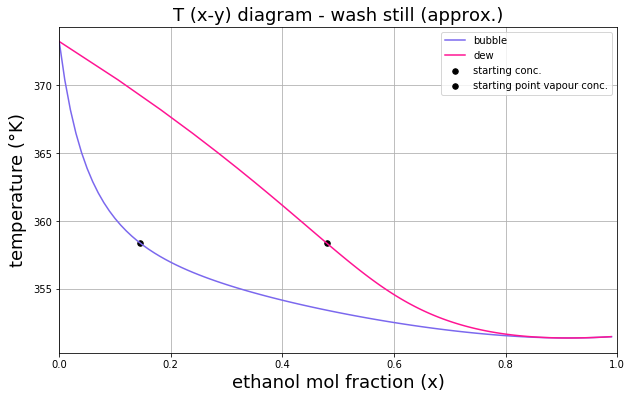

still starting point [vodka] (mol fraction): 0.145
Bubble point temperature of wash charge: 85.23 deg C
equilibrium vapour saturation of wash charge 0.145 mole fraction is 0.479
distilate (mol fraction): 78.047 % ABV


In [24]:
# creating a new plot with the distillation on it
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(xs, y_bubble,color='mediumslateblue',label='bubble')
ax.plot(x_dew,y_bubble,color='deeppink',label='dew')
ax.scatter(wash_start_mol_fraction,
           calculate_VLE_temperature_bubble(wash_start_mol_fraction),
           s=30,
           marker='o',
           c='black',
           label='starting conc.')
ax.scatter(calculate_vapour_fraction(wash_start_mol_fraction),
           calculate_VLE_temperature_bubble(wash_start_mol_fraction),
           s=30,
           marker='o',
           c='black',
           label='starting point vapour conc.')

ax.set_xlabel('ethanol mol fraction (x)',fontdict=font) 
ax.set_ylabel('temperature ($\degree$K)',fontdict=font) 
ax.set_title('T (x-y) diagram - wash still (approx.)',fontdict=font) 
plt.xlim(0.0,1.0)
ax.grid()
plt.legend()
wash_still_pic=os.path.join(os.getcwd(),'_output/wash_still_txy.png')
plt.savefig(wash_still_pic)
plt.show()
print('still starting point [vodka] (mol fraction): {:.3f}'.format(wash_start_mol_fraction))
print('Bubble point temperature of wash charge: {:.2f} deg C'.format(calculate_VLE_temperature_bubble(wash_start_mol_fraction)-273.15))
print('equilibrium vapour saturation of wash charge {:.3f} mole fraction is {:.3f}'.format(wash_start_mol_fraction,calculate_vapour_fraction(wash_start_mol_fraction)))
distilate=calculate_vapour_fraction(wash_start_mol_fraction)
vol_ethanol=calc_vm_ethanol(20.0+273.15)*distilate
vol_water=calc_vm_water(20.0+273.15)*(1.0-distilate)
print('distilate (mol fraction): {:.3f} % ABV'.format(calc_abv_from_pure_vol_fraction(vol_ethanol,vol_water,20.0+273.15)))

In [12]:
# import abv information and calculate mole fractions - assuming reference conditions
abv_file=os.path.join(os.getcwd(),'_data/measured_abvs.pkl')
run_abvs=pd.read_pickle(abv_file)
run_abvs['mol_ethanol']=(run_abvs['abv']*reference_ethanol_density/molar_mass_ethanol)
run_abvs['mol_water']=((100.0-run_abvs['abv'])*reference_water_density/molar_mass_water)
#run_abvs['ethanol_mol_fraction']=run_abvs['mol_ethanol']/(run_abvs['mol_ethanol']+run_abvs['mol_water'])
run_abvs['ethanol_mol_fraction']=lookup_mol_fraction_ethanol_from_abv(run_abvs['abv'],wash_distilate_temp+273.15)
# calculate bubble point temperature
vapour_temps=np.interp(run_abvs['ethanol_mol_fraction'],x_dew,y_bubble)
run_abvs['dew_point']=vapour_temps
#reverse order for interpolation
x_interp=np.flip(np.array(y_bubble))
y_interp=np.flip(xs)
bubble_points=np.interp(vapour_temps,x_interp,y_interp)
run_abvs['distilation_liquid_mol_fractions']=bubble_points
print(run_abvs)
distillation_datatable=os.path.join(os.getcwd(),'_output/experiment_abv_table.pkl')
run_abvs.to_pickle(distillation_datatable)

    sample   abv  mol_ethanol  mol_water  ethanol_mol_fraction   dew_point  \
0        1  79.6     1.363683   1.130340              0.501276  357.617209   
1        2  82.9     1.420217   0.947491              0.552630  355.931301   
2        3  82.9     1.420217   0.947491              0.552630  355.931301   
3        4  82.7     1.416791   0.958573              0.549311  356.034377   
4        5  82.5     1.413365   0.969654              0.546055  356.136813   
5        6  82.1     1.406512   0.991818              0.539555  356.343446   
6        7  81.6     1.397946   1.019522              0.531613  356.600393   
7        8  80.9     1.385954   1.058309              0.520725  356.959437   
8        9  79.3     1.358543   1.146963              0.496932  357.766394   
9       10  77.9     1.334559   1.224535              0.477211  358.450087   
10      11  74.6     1.278024   1.407384              0.434372  359.952783   
11      12  67.1     1.149537   1.822950              0.352240  

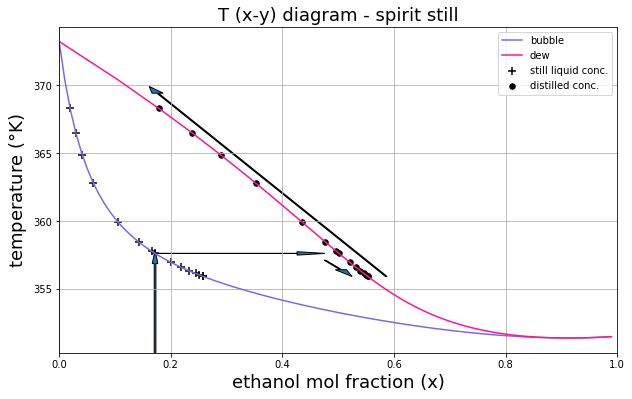

In [13]:
# creating a new plot with the distillation on it
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(xs, y_bubble,color='mediumslateblue',label='bubble')
ax.plot(x_dew,y_bubble,color='deeppink',label='dew')
ax.scatter(run_abvs['distilation_liquid_mol_fractions'],
           run_abvs['dew_point'],
           s=50,
           marker='+',
           c='black',
           label='still liquid conc.')
ax.scatter(run_abvs['ethanol_mol_fraction'],
           run_abvs['dew_point'],
           s=30,
           marker='o',
           c='black',
           label='distilled conc.')

ax.set_xlabel('ethanol mol fraction (x)',fontdict=font) 
ax.set_ylabel('temperature ($\degree$K)',fontdict=font) 
ax.set_title('T (x-y) diagram - spirit still',fontdict=font) 
plt.xlim(0.0,1.0)
ax.grid()
plt.legend()

arrow_delta=0.75

charge_x=run_abvs['distilation_liquid_mol_fractions'].iloc[0]
charge_x_vapour=run_abvs['ethanol_mol_fraction'].iloc[0]
charge_y=calculate_VLE_temperature_bubble(charge_x)
#plot starting point arrow - charge
plt.arrow(charge_x,0.0,0.0,charge_y-arrow_delta,
          length_includes_head=False,
          width=0.003,
          head_width=0.01,
          head_length=1)

# plot starting point vapour equilibrium
plt.arrow(charge_x,charge_y,charge_x_vapour-charge_x-0.025,0.0,
          length_includes_head=True,
          width=0.003,
          head_width=0.25,
         head_length=0.05)

# plot initial increase in vapour concentration
plt.arrow(charge_x_vapour-0.025,charge_y-0.5,0.55-charge_x_vapour,-1.2,
          length_includes_head=True,
          width=0.003,
          head_width=0.02,
         head_length=0.5)

# plot eventual decrease in vapour concentration
plt.arrow(charge_x_vapour+0.085,charge_y-1.7,-0.425,14.0,
          length_includes_head=True,
          width=0.003,
          head_width=0.02,
         head_length=0.5)

spirit_still_pic=os.path.join(os.getcwd(),'_output/spirit_still_txy.png')
plt.savefig(spirit_still_pic)
plt.show()

In [14]:
run_abvs.to_clipboard()